In [1]:
import dataset
from visualize import *

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import color
from datasets import load_dataset
from dotenv import load_dotenv
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
import lpips
import torch.nn.init as init
from fastprogress.fastprogress import master_bar, progress_bar

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"device: {device}")

device: mps


### Architecture

In [2]:
class Adain_Encoder(nn.Module):
    def __init__(self, in_channels, out_dim):
        super(Adain_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, out_dim, kernel_size=3, stride=2, padding=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        
        # Global average pooling
        x = self.global_avg_pool(x)        
        # Flatten
        x = x.view(x.size(0), -1)
        
        return x

# Example usage:
# Define input and output dimensions
in_channels = 3  # number of input channels
out_dim = 128  # size of the output representation

# Create an instance of the ConvNet
model = Adain_Encoder(in_channels, out_dim)

# Create a random input tensor
input_tensor = torch.randn(4, in_channels, 256, 256)

# Forward pass
output = model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 128])


In [3]:

class AdaIN(nn.Module):
    
    def __init__(self, style_dim, channels):
        super(AdaIN, self).__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale_transform = nn.Linear(style_dim, channels)
        self.style_shift_transform = nn.Linear(style_dim, channels)

        ## to ensure they learn different stuff | How tho?
        init.normal_(self.style_scale_transform.weight, mean=1.0, std=0.02)
        init.normal_(self.style_shift_transform.weight, mean=0.0, std=0.02)

        self.style_scale_transform.bias.data.fill_(1)  # Initialize scale to 1
        self.style_shift_transform.bias.data.fill_(0)  # Initialize shift to 0

    def forward(self, x, style):
        '''
        x - feature maps from the unet
        y - learned (jointly) from encoder

        return:
        same size as x
        '''
        # Normalize the input feature map
        normalized = self.instance_norm(x)
        
        # Extract style scale and shift parameters from the style vector
        scale = self.style_scale_transform(style)[:, :, None, None]
        shift = self.style_shift_transform(style)[:, :, None, None]
        
        # Apply scale and shift to the normalized feature map
        transformed = scale * normalized + shift
        
        return transformed

# Example usage:
# Define the dimensions
style_dim = 128  # dimensionality of the style vector
channels = 256    # number of channels in the feature map

# Create an instance of AdaIN
adain = AdaIN(style_dim, channels)

# Generate random input feature map and style vector
x = torch.randn(4, channels, 64, 64)  # Example input feature map
style = torch.randn(1, style_dim)     # Example style vector

# Apply AdaIN

output = adain(x, style)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 256, 64, 64])


In [4]:
mse_loss_fn = nn.MSELoss()
perceptual_loss_fn = lpips.LPIPS(net='alex').to(device)

def perceptual_and_MSE_loss(reproduced_image, original_image): 
    perceptual_loss = perceptual_loss_fn(reproduced_image, original_image).mean()
    mse_loss = mse_loss_fn(reproduced_image, original_image)
    return perceptual_loss + mse_loss

def plot_four(colored,grayscale,style,output):
    plt.figure(figsize=(15, 5))

    # Plot first image
    plt.subplot(1, 4, 1)
    plt.imshow(colored)
    plt.title('Ground truth - colored')
    plt.axis('off')

    # Plot second image
    plt.subplot(1, 4, 2)
    plt.imshow(grayscale,cmap='gray')
    plt.title('Input - grayscale')
    plt.axis('off')

    # Plot third image
    plt.subplot(1, 4, 3)
    plt.imshow(style)
    plt.title('Input - style')
    plt.axis('off')

    # Plot third image
    plt.subplot(1, 4, 4)
    plt.imshow(output)
    plt.title('Ouptut - colorized')
    plt.axis('off')

    plt.show()

def plot_histograms(latent_space_values):
    # Limit the number of plots to 10 if the list is longer
    num_plots = min(len(latent_space_values), 10)
    # Calculate the number of rows and columns for the grid
    num_rows = (num_plots + 4) // 5  # Ensure at least 1 row
    num_cols = min(num_plots, 5)
    # Create a figure and axis objects
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    # Flatten the axes if necessary
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    # Plot histograms
    for i in range(num_plots):
        row_index = i // num_cols
        col_index = i % num_cols
        if num_rows == 1:
            ax = axes[col_index]
        else:
            ax = axes[row_index, col_index]
        ax.hist(latent_space_values[i]["image"].detach().cpu().numpy().flatten(), bins=50)
        ax.set_title(f'Array {i+1}')
    # Hide empty subplots
    for i in range(num_plots, num_rows * num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/matteom/miniconda3/envs/torch/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
class UNetAdaiN(nn.Module):
    def __init__(self, colorspace="RGB", adain_latent_dim=32, dropout_rate=None, verbose=False):
        self.colorspace = colorspace
        self.dropout_rate = dropout_rate
        self.verbose = verbose
        super(UNetAdaiN, self).__init__()
        if self.colorspace == 'RGB':
            in_C = 1
            out_C = 3
        elif self.colorspace == 'LAB':
            in_C = 1
            out_C = 2
        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv5_2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(256, 128, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(128, 64, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(64, 32, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(16, 16, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(32, 16, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        self.conv10 = nn.Conv2d(16, out_C, 1)

        '''
        Conv1 shape torch.Size([16, 64, 128, 128])
        Conv2 shape torch.Size([16, 128, 64, 64])
        Conv3 shape torch.Size([16, 256, 32, 32])
        Conv4 shape torch.Size([16, 512, 16, 16])
        Conv5 shape torch.Size([16, 512, 8, 8])
        '''

        self.encoder_adain1 = AdaIN(adain_latent_dim, 16)
        self.encoder_adain2 = AdaIN(adain_latent_dim, 32)
        self.encoder_adain3 = AdaIN(adain_latent_dim, 64)
        self.encoder_adain4 = AdaIN(adain_latent_dim, 128)
        self.encoder_adain5 = AdaIN(adain_latent_dim, 128)

        self.decoder_adain4 = AdaIN(adain_latent_dim, 128)
        self.decoder_adain3 = AdaIN(adain_latent_dim, 64)
        self.decoder_adain2 = AdaIN(adain_latent_dim, 32)
        self.decoder_adain1 = AdaIN(adain_latent_dim, 16)

        self.style_encoder = Adain_Encoder(in_channels=out_C, out_dim=adain_latent_dim)
       

    def forward(self,x,style_image):
        x=x.to(device)
        print(f"Input shape: {x.shape}") if self.verbose==True else None
        style_image = style_image.to(device)
        print(f"Style image shape: {style_image.shape}") if self.verbose==True else None
        style = self.style_encoder(style_image).to(device)
        print(f"Style embedding shape: {style.shape}") if self.verbose==True else None

        # Encoder
        conv1 = self.conv1(x)
        conv1 = nn.Dropout2d(p=self.dropout_rate)(conv1) if self.dropout_rate is not None else None
        conv1 = self.encoder_adain1(x,style) ## AdaIN
        print(f"Conv1 shape {conv1.shape}") if self.verbose==True else None

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        conv2 = nn.Dropout2d(p=self.dropout_rate)(conv2) if self.dropout_rate is not None else None
        conv2 = self.encoder_adain2(conv2,style) ## AdaIN
        print(f"Conv2 shape {conv2.shape}") if self.verbose==True else None

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        conv3 = nn.Dropout2d(p=self.dropout_rate)(conv3) if self.dropout_rate is not None else None
        conv3 = self.encoder_adain3(conv3,style) ## AdaIN
        print(f"Conv3 shape {conv3.shape}") if self.verbose==True else None

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4_1 = self.conv4(maxpooled_3to4)
        conv4_1 = nn.Dropout2d(p=self.dropout_rate)(conv4_1) if self.dropout_rate is not None else None
        conv4_1 = self.encoder_adain4(conv4_1,style) ## AdaIN
        print(f"Conv4_1 shape {conv4_1.shape}") if self.verbose==True else None
        conv4_2 = self.conv4_2(conv4_1)
        conv4_2 = nn.Dropout2d(p=self.dropout_rate)(conv4_2) if self.dropout_rate is not None else None
        conv4_2 = self.encoder_adain4(conv4_2,style) ## AdaIN
        print(f"Conv4_2 shape {conv4_2.shape}") if self.verbose==True else None

        maxpooled_4to5 = self.maxpool_4to5(conv4_2)
        conv5_1 = self.conv5(maxpooled_4to5)
        conv5_1 = nn.Dropout2d(p=self.dropout_rate)(conv5_1) if self.dropout_rate is not None else None
        conv5_1 = self.encoder_adain5(conv5_1,style) ## AdaIN
        print(f"Conv5_1 shape {conv5_1.shape}") if self.verbose==True else None
        conv5_2 = self.conv5_2(conv5_1)
        conv5_2 = nn.Dropout2d(p=self.dropout_rate)(conv5_2) if self.dropout_rate is not None else None
        conv5_2 = self.encoder_adain5(conv5_2,style) ## AdaIN
        print(f"Conv5_2 shape {conv5_2.shape}") if self.verbose==True else None


        # Decoder
        conv_transpose6 = self.conv_transpose_5to6(conv5_2)
        conv_transpose6 = self.decoder_adain4(conv_transpose6,style)
        print(f"Conv_transpose6 shape {conv_transpose6.shape}, concatenates to conv4_2") if self.verbose==True else None
        concatenation_5to6 = torch.cat((conv4_2,conv_transpose6),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)
        conv6 = nn.Dropout2d(p=self.dropout_rate)(conv6) if self.dropout_rate is not None else None
        print(f"Conv6 shape {conv6.shape}") if self.verbose==True else None

        conv_transpose7 = self.conv_transpose_6to7(conv6)
        conv_transpose7 = self.decoder_adain3(conv_transpose7,style)
        print(f"Conv_transpose7 shape {conv_transpose7.shape}, concatenates to conv3") if self.verbose==True else None
        concatenation_6to7 = torch.cat((conv3, conv_transpose7),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)
        conv7 = nn.Dropout2d(p=self.dropout_rate)(conv7) if self.dropout_rate is not None else None
        print(f"Conv7 shape {conv7.shape}") if self.verbose==True else None

        conv_transpose8 = self.conv_transpose_7to8(conv7)
        conv_transpose8 = self.decoder_adain2(conv_transpose8,style)
        print(f"Conv_transpose8 shape {conv_transpose8.shape}, concatenates to conv2") if self.verbose==True else None
        concatenation_7to8 = torch.cat((conv2, conv_transpose8),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)
        conv8 = nn.Dropout2d(p=self.dropout_rate)(conv8) if self.dropout_rate is not None else None
        print(f"Conv8 shape {conv8.shape}") if self.verbose==True else None

        conv_transpose9 = self.conv_transpose8to9(conv8)
        conv_transpose9 = self.decoder_adain1(conv_transpose9,style)
        print(f"Conv_transpose9 shape {conv_transpose9.shape}, concatenates to conv1") if self.verbose==True else None
        concatenation_8_to9 = torch.cat((conv1, conv_transpose9),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)
        conv9 = nn.Dropout2d(p=self.dropout_rate)(conv9) if self.dropout_rate is not None else None
        print(f"Conv9 shape {conv9.shape}") if self.verbose==True else None

        output = self.conv10(conv9)
        print(f"Output shape {output.shape}") if self.verbose==True else None

        if self.colorspace == 'LAB':
            output = torch.cat((x,output),1)
            print(f"Output shape after concatenation of L channel {output.shape}") if self.verbose==True else None

        return style, output

    

    def train_model(self, train_loader, val_loader,
                    epochs=54, 
                    lr=0.0001, 
                    optimizer=torch.optim.Adam, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB',
                    val_check_every=3,
                    plot_every=12,
                    plotting_samples=None,
                    latent_space_test_images=None):

        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        loss_archive = {"training": [], "validation":[]}

        mb = master_bar(range(epochs))
        for epoch in mb:
            training_loss = 0
            for i, batch_data in progress_bar(enumerate(train_loader), total=len(train_loader), parent=mb):
                
                # Input grayscale and color image
                grayscale_images = batch_data['grayscale_image'].to(device)
                if colorspace == 'RGB':
                    colour_images = batch_data['image'].to(device)
                elif colorspace == 'LAB':
                    colour_images = batch_data['image'][:,1:,:,:].to(device)
                # Forward pass
                optimizer.zero_grad()
                _, reproduced_images = self(grayscale_images,colour_images)
                reproduced_images = reproduced_images.to(device)
                # Loss
                loss = perceptual_and_MSE_loss(reproduced_images, batch_data['image'].to(device))
               
                training_loss += loss.item()
                loss.backward()
                optimizer.step()
            
            
            # Average training loss and append to achive
            training_loss /= len(train_loader)
            loss_archive["training"].append(training_loss)            
            with torch.no_grad():
                if (epoch)%val_check_every == 0 or (epoch + 1) == epochs:
                    valdiation_loss = 0

                    for val_data in val_loader:
                        # Input grayscale and color image
                        grayscale_images = val_data['grayscale_image'].to(device)
                        if colorspace == 'RGB':
                            colour_images = val_data['image'].to(device)
                        elif colorspace == 'LAB':
                            colour_images = val_data['image'][:,1:,:,:].to(device)
                            
                        # Forward pass
                        _, reproduced_image = self(grayscale_images,colour_images)
                        reproduced_images = reproduced_images.to(device)
                       
                        loss = perceptual_and_MSE_loss(reproduced_image, val_data['image'].to(device))
                        
                        valdiation_loss += loss.item()
                        
                    valdiation_loss /= len(val_loader)
                    loss_archive["validation"].append(valdiation_loss)                


                    if valdiation_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                        state_diction = self.state_dict()
                        best_val_loss = valdiation_loss
                        for key in state_diction.keys():
                            state_diction[key] = state_diction[key].to(torch.device('cpu'))
                        torch.save(state_diction, (save_path+save_name_prefix+f"_best_model.pth.tar"))

                    #construct df with losses
                    loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  
                                            'training_loss':loss_archive['training'], 
                                            'validation_loss': loss_archive['validation']})
                    loss_df.to_csv(save_path+save_name_prefix+"_loss.csv", index=False)

                    # Plot losses
                    plt.clf()
                    plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                    plt.plot(loss_df['epoch'], loss_df['validation_loss'].interpolate(method='linear'), label='Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.title('Training and Validation Loss')
                    plt.legend()
                    plt.savefig(save_path+save_name_prefix+'_loss_plot.png')
                    plt.clf()

                    # Plot images three triplets of images
                    if (epoch)%plot_every==0 and plotting_samples is not None:
                        if colorspace == 'RGB':
                            # 0
                            ground_truth = plotting_samples[0]['image']
                            grayscale_image = plotting_samples[0]['grayscale_image']
                            _,recreated_image = self(grayscale_image.unsqueeze(0).to(device),
                                                ground_truth.unsqueeze(0).to(device))
                            recreated_image = recreated_image.detach().cpu().squeeze(0)
                            plot_four(colored=ground_truth.permute(1,2,0).numpy(),
                                    grayscale=grayscale_image.numpy().squeeze(0),
                                    style=ground_truth.permute(1,2,0).numpy(),
                                    output=recreated_image.permute(1,2,0).numpy())
                            # 1
                            ground_truth = plotting_samples[1]['image']
                            grayscale_image = plotting_samples[1]['grayscale_image']
                            _,recreated_image = self(grayscale_image.unsqueeze(0).to(device),
                                                ground_truth.unsqueeze(0).to(device))
                            recreated_image = recreated_image.detach().cpu().squeeze(0)
                            plot_four(colored=ground_truth.permute(1,2,0).numpy(),
                                    grayscale=grayscale_image.numpy().squeeze(0),
                                    style=ground_truth.permute(1,2,0).numpy(),
                                    output=recreated_image.permute(1,2,0).numpy())
                        elif colorspace == 'LAB':
                            # 0
                            ground_truth = plotting_samples[0]['image']
                            grayscale_image = plotting_samples[0]['grayscale_image']
                            input_encoder = ground_truth[1:,:,:].unsqueeze(0).to(device)
                            lab2rgb = dataset.LABtoRGB()
                            print(f"ground_truth shape {ground_truth.shape}")
                            original_color = lab2rgb(ground_truth.to(device))

                            _,recreated_image = self(grayscale_image.unsqueeze(0).to(device),
                                                    input_encoder)
                            
                            recreated_image = lab2rgb(recreated_image.detach().cpu().squeeze(0))
                            print(f"recreated_image shape: {recreated_image.shape}")
                            plot_four(colored=original_color.permute(1,2,0).numpy(),
                                    grayscale=grayscale_image.numpy().squeeze(0),
                                    style=original_color.permute(1,2,0).numpy(),
                                    output=recreated_image.permute(1,2,0).numpy())
                            # 1
                            ground_truth = plotting_samples[1]['image']
                            grayscale_image = plotting_samples[1]['grayscale_image']
                            input_encoder = ground_truth[1:,:,:].unsqueeze(0).to(device)
                            lab2rgb = dataset.LABtoRGB()
                            print(f"ground_truth shape {ground_truth.shape}")
                            original_color = lab2rgb(ground_truth.to(device))

                            _,recreated_image = self(grayscale_image.unsqueeze(0).to(device),
                                                    input_encoder)
                            
                            recreated_image = lab2rgb(recreated_image.detach().cpu().squeeze(0))
                            print(f"recreated_image shape: {recreated_image.shape}")
                            plot_four(colored=original_color.permute(1,2,0).numpy(),
                                    grayscale=grayscale_image.numpy().squeeze(0),
                                    style=original_color.permute(1,2,0).numpy(),
                                    output=recreated_image.permute(1,2,0).numpy())
                        
                    if (epoch)%plot_every==0 and latent_space_test_images is not None:    
                        plot_histograms(latent_space_values=list(latent_space_test_images))
                        
                else:
                    loss_archive["validation"].append(np.nan)


## Training

In [9]:
BATCH_SIZE = 16
RESOLUTION = (128,128)
COLORSPACE = 'RGB'
TRAIN_SIZE = 100000
VAL_SIZE = 1000
ADAIN_LATENT_SPACE_DIM = 32

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace=COLORSPACE,resolution=RESOLUTION)
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)

Dataset loaded successfully
Data loader prepared successfully


In [10]:
def load_model_from_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model = UNetAdaiN(colorspace=COLORSPACE,adain_latent_dim=ADAIN_LATENT_SPACE_DIM, dropout_rate=0.1, verbose=False)
        model.load_state_dict(checkpoint)
        print("Model loaded successfully from checkpoint.")
        return model.to(device)
    else:
        print("Checkpoint file does not exist.")
        return None

Device is:  mps
Model loaded successfully from checkpoint.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

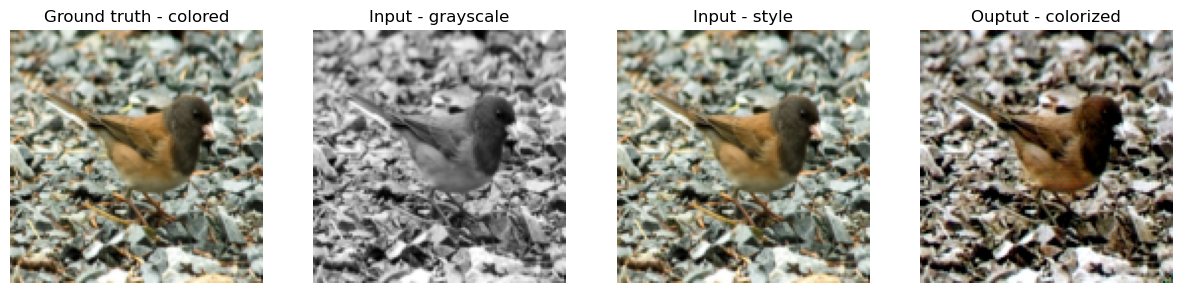

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


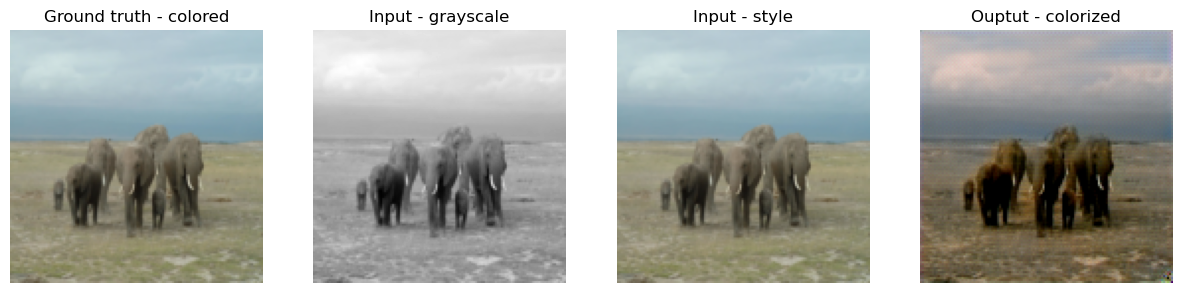

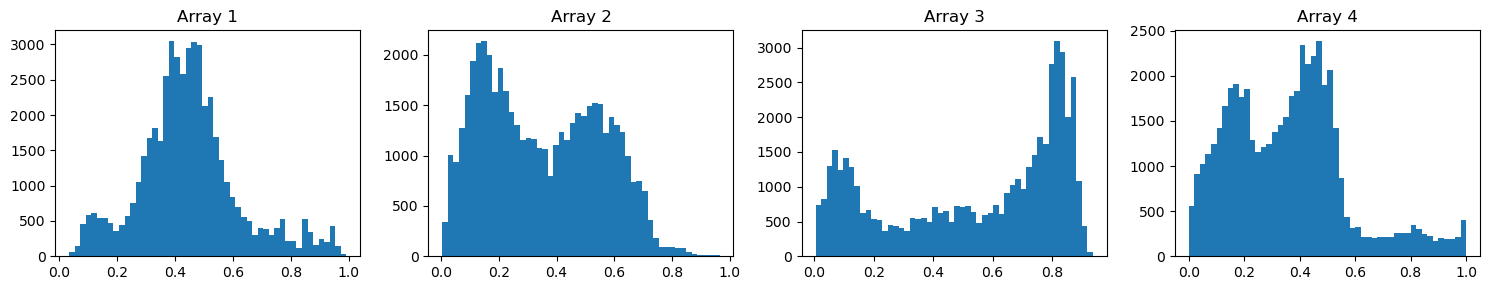

In [11]:
print("Device is: ", device)

model = load_model_from_checkpoint("./implicit_scarsity_experiments/RGB_Latent32_best_model.pth.tar")
#model = UNetAdaiN(colorspace=COLORSPACE, adain_latent_dim=ADAIN_LATENT_SPACE_DIM, dropout_rate=0.1, verbose=False)
model = model.to(device)

model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                        epochs=10, lr=0.00001, optimizer=torch.optim.Adam,
                        save_path= 'implicit_scarsity_experiments/', 
                        save_name_prefix='/RGB_Latent32_trsize100k_valsize1k',
                        colorspace=COLORSPACE, val_check_every=1, plot_every=1, 
                        plotting_samples=[list(train_data)[2], list(validation_data)[7]],
                        latent_space_test_images=list(validation_data)[:4])

## Testing style transfer

In [ ]:
s_train_data, s_validation_data = dataset.prepare_styles_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace=COLORSPACE,resolution=RESOLUTION)
_, s_validation_loader = dataset.prepare_styles_dataloader(s_train_data, s_validation_data, batch_size=BATCH_SIZE)

In [ ]:
# Only to choose painings
list_paintings =list(s_validation_data)
if COLORSPACE =='LAB':
    lab2rgb = dataset.LABtoRGB()
    list_paintings = [{'image':lab2rgb(image['image'])} for image in list_paintings]
plot_four(list_paintings[0]['image'].permute(1,2,0).numpy(),
          list_paintings[1]['image'].permute(1,2,0).numpy(),
          list_paintings[2]['image'].permute(1,2,0).numpy(),
          list_paintings[3]['image'].permute(1,2,0).numpy())
plot_four(list_paintings[4]['image'].permute(1,2,0).numpy(),
          list_paintings[5]['image'].permute(1,2,0).numpy(),
          list_paintings[6]['image'].permute(1,2,0).numpy(),
          list_paintings[7]['image'].permute(1,2,0).numpy())
plot_four(list_paintings[8]['image'].permute(1,2,0).numpy(),
            list_paintings[9]['image'].permute(1,2,0).numpy(),
            list_paintings[10]['image'].permute(1,2,0).numpy(),
            list_paintings[11]['image'].permute(1,2,0).numpy())
plot_four(list_paintings[12]['image'].permute(1,2,0).numpy(),
            list_paintings[13]['image'].permute(1,2,0).numpy(),
            list_paintings[14]['image'].permute(1,2,0).numpy(),
            list_paintings[15]['image'].permute(1,2,0).numpy())


In [ ]:
# Test colorization against different style images

model = load_model_from_checkpoint("./implicit_scarsity_experiments/LAB_Latent32_trsize50000_valsize500_best_model.pth.tar")
model=model.to(device)
plotting_sample=list(validation_data)[7]

style_image = list(s_validation_data)[10]['image']

if COLORSPACE == 'RGB':
        # 0
        ground_truth = plotting_sample['image']
        grayscale_image = plotting_sample['grayscale_image']
        _,recreated_image = model(grayscale_image.unsqueeze(0).to(device),
                        ground_truth.unsqueeze(0).to(device))
        recreated_image = recreated_image.detach().cpu().squeeze(0)
        plot_four(colored=ground_truth.permute(1,2,0).numpy(),
                grayscale=grayscale_image.numpy().squeeze(0),
                style=ground_truth.permute(1,2,0).numpy(),
                output=recreated_image.permute(1,2,0).numpy())
        # 1
        ground_truth = plotting_sample['image']
        grayscale_image = plotting_sample['grayscale_image']
        _,recreated_image = model(grayscale_image.unsqueeze(0).to(device),
                        style_image.unsqueeze(0).to(device))
        recreated_image = recreated_image.detach().cpu().squeeze(0)
        plot_four(colored=ground_truth.permute(1,2,0).numpy(),
                grayscale=grayscale_image.numpy().squeeze(0),
                style=style_image.permute(1,2,0).numpy(),
                output=recreated_image.permute(1,2,0).numpy())
elif COLORSPACE == 'LAB':
        # 0
        ground_truth = plotting_sample['image']
        grayscale_image = plotting_sample['grayscale_image']
        input_encoder = ground_truth[1:,:,:].unsqueeze(0).to(device)
        lab2rgb = dataset.LABtoRGB()
        original_color = lab2rgb(ground_truth.to(device))

        _,recreated_image = model(grayscale_image.unsqueeze(0).to(device),
                                input_encoder)

        recreated_image = lab2rgb(recreated_image.detach().cpu().squeeze(0))
        plot_four(colored=original_color.permute(1,2,0).numpy(),
                grayscale=grayscale_image.numpy().squeeze(0),
                style=original_color.permute(1,2,0).numpy(),
                output=recreated_image.permute(1,2,0).numpy())
        # 1
        ground_truth = plotting_sample['image']
        grayscale_image = plotting_sample['grayscale_image']
        input_encoder = style_image[1:,:,:].unsqueeze(0).to(device)
        lab2rgb = dataset.LABtoRGB()
        
        original_color = lab2rgb(ground_truth.to(device))

        _,recreated_image = model(grayscale_image.unsqueeze(0).to(device),
                                input_encoder)

        recreated_image = lab2rgb(recreated_image.detach().cpu().squeeze(0))
        style_image = lab2rgb(style_image)
        plot_four(colored=original_color.permute(1,2,0).numpy(),
                grayscale=grayscale_image.numpy().squeeze(0),
                style=style_image.permute(1,2,0).numpy(),
                output=recreated_image.permute(1,2,0).numpy())